In [1]:
# First need to import qiskit, numpy, math, matplotlib, and pylatexenc, along with and some important functions from qiskit
import qiskit
import numpy as np
import math as m
import matplotlib.pyplot as plt
import pylatexenc
import sympy as sp

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.circuit.library import RXGate, RYGate, RZGate, QFT
from qiskit.quantum_info import Statevector, Operator

In this project, we will construct a Qiskit function that takes as input two positive integers $a$ and $N$ such that $1<a<N$, and outputs the quantum gate $U$ such that 
$$U|x\rangle_1|y\rangle_n = \begin{cases}
    |x\rangle_1|ay\mod N\rangle_n && \text{if }x=1\text{ and }y<N \\
    |x\rangle_1|y\rangle_n && \text{otherwise}
\end{cases}$$
where $n=\lceil\log_2(N)\rceil$. 

## The Adder Gate

First we construct a variant of Draper's adder circuit which does the following:
1. Apply Quantum Fourier Transform on n-qubit state $b$ expressed in binary (i.e. b_0b_1...b_{n-1} such that b = b_0+2^1b_1+...+2^{n-1}b_{n-1})
2. Apply n-qubit gate $\bigotimes\limits_{k=0}^{n-1}R_Z\left(\frac{2\pi a}{2^{n-k}}\right)$ 
3. Apply inverse Quantum Fourier Transform
This will take the state $|b\rangle$ as input, and output $|b+a\rangle$. 

### State Preparation

Before constructing the Adder Gate, we need to be able prepare the state $|b\rangle$, where $b$ is any integer between $0$ and $2^n-1$. 

To convert an arbitrary positive integer $b$ into a binary string of length $n$, we invoke the format function in python. For example, the following code converts $b=1$ into a binary string of length $4$:

In [2]:
format(1, "04b")

'0001'

In [3]:
def state_prep(b, N):
    n = m.ceil(m.log2(N))
    
    qr = QuantumRegister(size = n, name = "b")
    qc = QuantumCircuit(qr, name= f"Preparing {b}")
    
    b_to_binary = format(b, f"0{n}b")  # represents b as a binary string of length n
    for i, bit in enumerate(reversed(b_to_binary)):
        # if b_i = 1, apply X gate to ith qubit (note that Qiskit orders qubits in circuit in reverse order)
        if bit == "1":
            qc.x(qr[i])
    
    return qc

Let's check that this works by inputting $b=8$ and $N=15$ and seeing what vector is output (it should be $|1000\rangle$).  

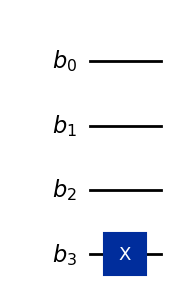

In [4]:
qc = state_prep(8, 15)

qc.draw("mpl")

In [5]:
psi = Statevector(qc)
psi.draw("Latex")

<IPython.core.display.Latex object>

Great!

### Constructing Circuit for Adder Gate

Now that we have the means to prepare $b$, it is straightforward to construct the Adder Gate. 

In [6]:
def adder_circ(a, N):
    n = m.ceil(m.log2(N))
    
    qr = QuantumRegister(n, name="b")
    qc = QuantumCircuit(qr, name=f"Add {a} Gate")

    # Apply QFT
    qc.compose(QFT(num_qubits=n).to_gate(), inplace=True)

    # Apply RZ gates to each qubit
    for k in range(n):
        theta = (2*np.pi*a)/(2**(n - k))
        qc.rz(theta, qr[k])

    # Apply inverse QFT
    qc.compose(QFT(num_qubits=n, inverse=True).to_gate(), inplace=True)

    return qc

Applying adder_circ with $N=15$, $a=8$, and $b=0$ should output $|8\rangle = |1000\rangle$. Let's check that.

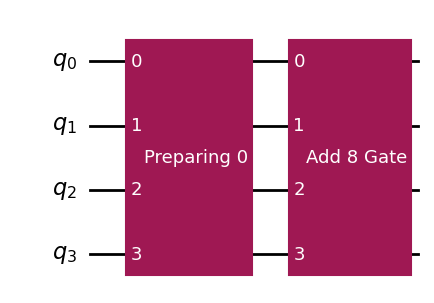

In [7]:
N = 15
a = 8
b = 0

qc = QuantumCircuit(m.ceil(m.log2(N)))

qc.compose(state_prep(b, N).to_gate(), inplace=True)
qc.compose(adder_circ(a, N).to_gate(), inplace=True)

qc.draw("mpl")

In [8]:
psi = Statevector(qc)
psi.draw("Latex")

<IPython.core.display.Latex object>

This works (up to a phase, which we can disregard since it is physically meaningless). Let's try one more example, with $N=15$, $a = 12$ and $b = 3$. This should output $|15\rangle = |1111\rangle$ (up to a phase). 

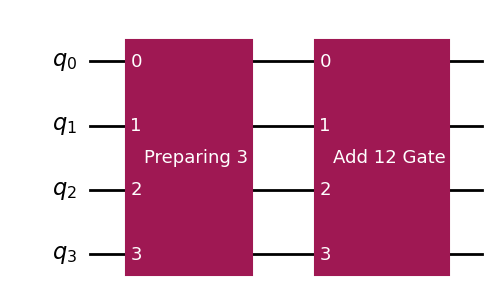

In [9]:
N = 15
a = 12
b = 3

qc = QuantumCircuit(m.ceil(m.log2(N)))

qc.compose(state_prep(b, N).to_gate(), inplace=True)
qc.compose(adder_circ(a, N).to_gate(), inplace=True)

qc.draw("mpl")

In [10]:
psi = Statevector(qc)
psi.draw("Latex")

<IPython.core.display.Latex object>

Good!

## The Modular Adder Gate

Next, we construct a circuit which performs modular arithmetic; in particular, given a state $b$, it will add $a$ to it modulo $N$. This circuit requires n+1 qubits: n qubits for $b$ and 1 ancillary qubit. The circuit does the following:
1. Apply adder_circ(a, N) to the prepared n-qubit state b expressed in binary
2. Apply the inverse of adder_circ(N ,N) to the n qubits used to prepare b
3. Apply CX gate with the most significant bit as the control and the ancilla as target
4. Apply controlled-adder_circ(N, N) with the ancilla as control and the n qubits used to prepare b as the target
5. Apply inverse-adder_circ(a, N) to the n qubits used to prepare b
6. Apply X gate on the most significant bit
7. Apply CX gate with the most significant as control and ancilla as the target
8. Apply X gate to the most significant bit
9. Apply adder_circ(a, N) to the n qubits used to prepare b

In [11]:
def mod_adder(a, N):
    n = m.ceil(m.log2(N))
    
    add_a_gate = adder_circ(a, N).to_gate()
    add_N_gate = adder_circ(N, N).to_gate()
    controlled_add_N_gate = add_N_gate.control(1)
    
    ar = AncillaRegister(1, "a")
    qr = QuantumRegister(size = n, name = "b")
    qc = QuantumCircuit(ar, qr, name = f"Add {a} (Mod {N})")
    
    qc.append(add_a_gate, qr)
    qc.append(add_N_gate.inverse(), qr)
    qc.cx(qr[n-1], ar)
    qc.append(controlled_add_N_gate, ar[:] + qr[:])
    qc.append(add_a_gate.inverse(), qr)
    qc.x(qr[n-1])
    qc.cx(qr[n-1], ar)
    qc.x(qr[n-1])
    qc.append(add_a_gate, qr)
    
    return qc

Let's test this to see if it works. In the example we'll set $N=15$, $a=12$, and $b=3$. After preparing the $b$ state in binary, we should get $|0\rangle_n = |0000\rangle$. 

NOTE: since our circuit requires $n+1$ bits, and since I have ordered the bits in such a way that the ancilla comes first, we will obtain an $n+1$ qubit state and can <b>disregard the least significant bit</b> to see the actual output of the circuit. 

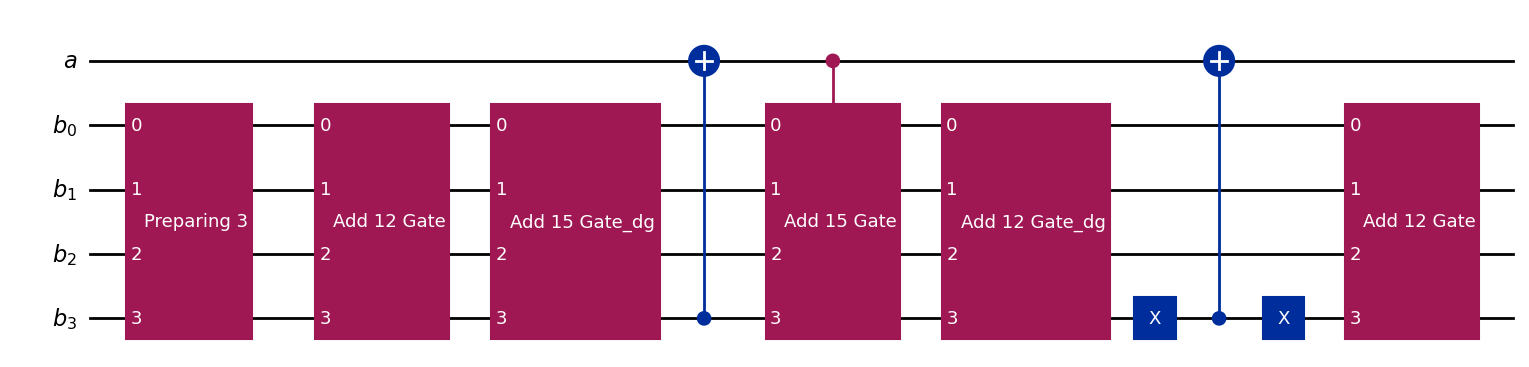

In [12]:
N = 15
a = 12
b = 3

n = m.ceil(m.log2(N))

ar = AncillaRegister(size=1, name="a")
qr = QuantumRegister(size = n, name="b")
qc = QuantumCircuit(ar, qr)

qc.compose(state_prep(b, N).to_gate(), qr, inplace=True)
qc.compose(mod_adder(a, N), inplace=True)


qc.draw("mpl")

In [13]:
psi = Statevector(qc)
psi.draw("Latex")

<IPython.core.display.Latex object>

As you can see, after disregarding the least significant bit, we obtain $|0000\rangle$, which is precisely the answer we were expecting!

Let's try one more example with $N=15$, $a=14$ and $b=4$. This should give us $|3\rangle_n = |0011\rangle$. 

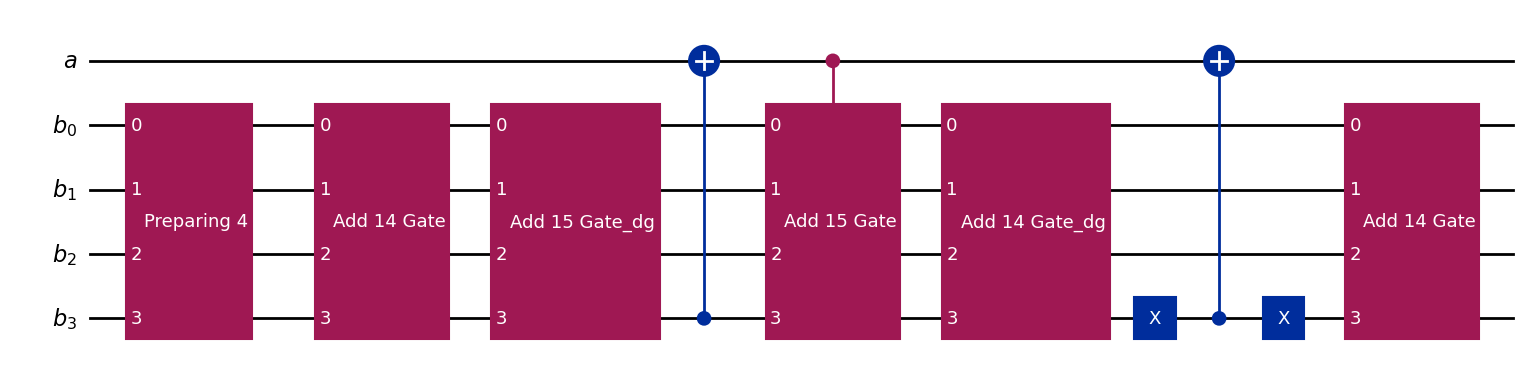

In [14]:
N = 15
a = 14
b = 4

n = m.ceil(m.log2(N))

ar = AncillaRegister(size=1, name="a")
qr = QuantumRegister(size = n, name="b")
qc = QuantumCircuit(ar, qr)

qc.compose(state_prep(b, N).to_gate(), qr, inplace=True)
qc.compose(mod_adder(a, N), inplace=True)


qc.draw("mpl")

In [15]:
psi = Statevector(qc)
psi.draw("Latex")

<IPython.core.display.Latex object>

Great!

## The Controlled Multiplier Gate

Next, we construct a circuit multiplies an n-qubit $x$ by $a$ and adds the state $b$ to the sum modulo N. This circuit requires 2n+2 qubits: n qubits for $x$, n+1 qubits for adding $b$ modulo $N$, and 1 control qubit. The circuit will then do the following:
1. Apply QFT to n-qubit b prepared in binary
2. Apply control-controlled-mod_adder$(2^ka, N)$, with the first control the control qubit, the second control the $k^{th}$ qubit of x, and the target being the n-qubits that initially made up b
3. Apply inverse QFT on the n-qubits that initially made up b

In [16]:
def cmult(a, N):
    
    n = m.ceil(m.log2(N))
    
    mod_adders = []  # Initialize list of mod_adder gates
    cc_mod_adders = []  # Initialize controlled-controlled-mod_adder gates
    for k in range(n):
        mod_adders.append(mod_adder(a*(2**k), N).to_gate()) 
        cc_mod_adders.append(mod_adders[k].control(2))  
        
    qr1 = QuantumRegister(size = n, name = "y")
    qr2 = QuantumRegister(size = n+1, name = "b")
    cr = QuantumRegister(size = 1, name = "c")
    qc = QuantumCircuit(qr1, cr, qr2, name = f"{a}x+b (Mod {N})")
    
    qc.x(cr[0])  # Apply X to control bit, otherwise circuit does nothing
    for k in range(n):
        qc.append(cc_mod_adders[k], [cr[0], qr1[k]] + qr2[:])
    
    return qc

Let's see if this work by setting $N=15$, $a=5$, $b=5$, and $y=2$. This $|ax+b \mod N\rangle_n$ should give us $|0\rangle_n = |0000\rangle$. 

NOTE: since our circuit requires $2n+2$ qubits we will obtain an 10 qubit state, but due to how I ordered the circuits we can <b>disregard the least significant 6 bits</b>; that is, it is <b>the 4 most significant bits</b> that should <b>give the disired output</b>. 

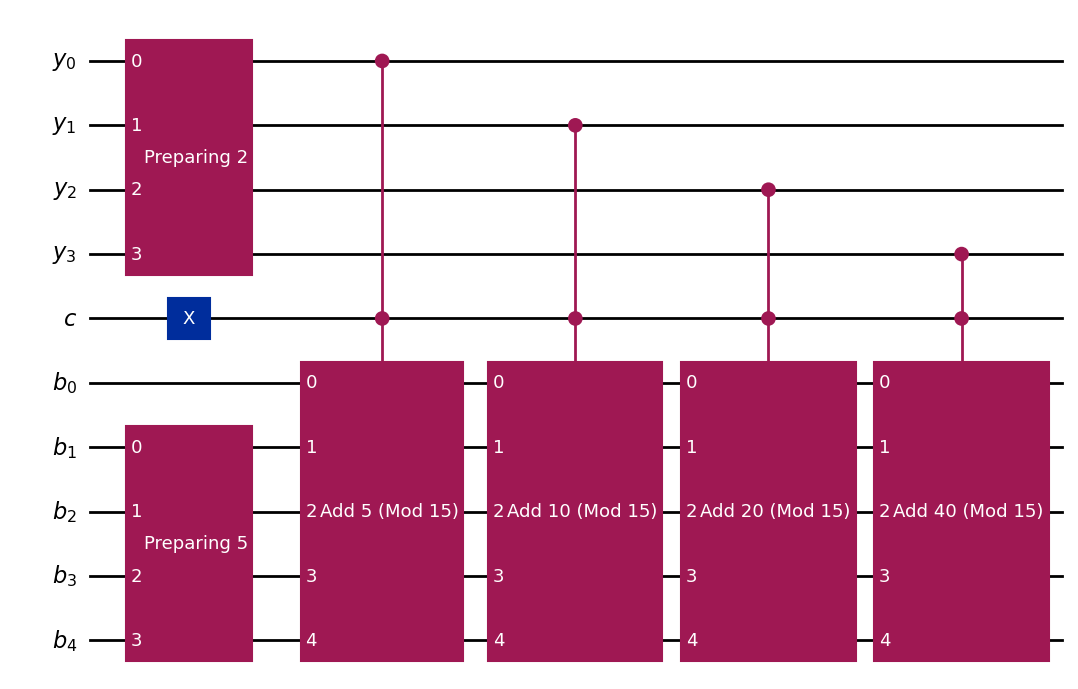

In [17]:
N = 15
a = 5
b = 5
y = 2

n = m.ceil(m.log2(N))

qr1 = QuantumRegister(size=n, name="y")
qr2 = QuantumRegister(size = n+1, name="b")
cr = QuantumRegister(size=1, name="c")
qc = QuantumCircuit(qr1, cr, qr2)

qc.compose(state_prep(y, N).to_gate(), qr1, inplace=True)
qc.compose(state_prep(b, N).to_gate(), qr2[-n:], inplace=True)
qc.compose(cmult(a, N), inplace=True)


qc.draw("mpl")

In [18]:
psi = Statevector(qc)
psi.draw("Latex")

<IPython.core.display.Latex object>

Excellent!

## The Controlled $U_a$ Gate

Lastly, we construct a circuit acts on an $n+1$ qubit in the following way: it will multiply an n-qubit $x$ by $a$ modulo $N$ if the the control qubit $c = 1$, and does nothing if the control qubit $c = 0$. This circuit requires $2n+3$ qubits: 1 qubit for the control, n qubits for $x$, and another n+2 qubits initialized each to $0$ so that we can apply cmult(a,N) constructed above. The circuit will then do the following:
1. Apply a controlled-cmult(a,N) gate
2. Apply a controlled SWAP gate swapping each of the qubits in $x$ to the initialized $0$ qubits
3. Apply the inverse of the controlled-cmult(a,N) gate

First, we need to construct a helping function which creates a controlled gate that swaps the qubits from one register to another. 

In [19]:
def cSWAP(cr, qr1, qr2):
    
    qc = QuantumCircuit(qr1, cr, qr2, name = "cSWAP")
    
    for i in range(n):
        qc.cswap(cr[0], qr1[i], qr2[i+2])
        
    return qc

Let's quickly check that it does what we expect. 

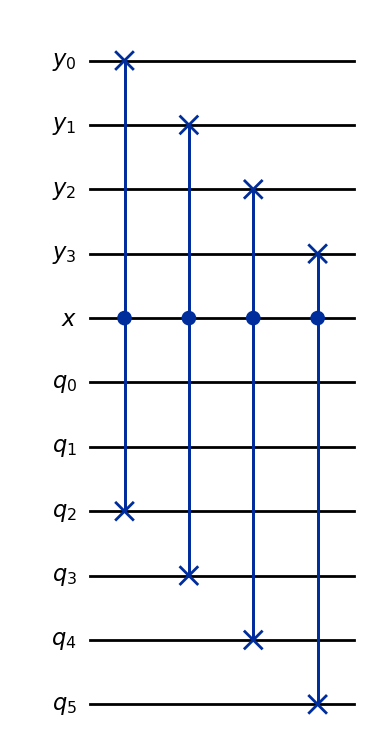

In [20]:
qr1 = QuantumRegister(size = n, name = "y")
cr = QuantumRegister(size = 1, name = "x")
qr2 = QuantumRegister(size = n+2, name = "q")

qc = QuantumCircuit(qr1, cr, qr2)

qc.compose(cSWAP(cr, qr1, qr2), inplace=True)

qc.draw("mpl")

That looks right. Now onto the controlled $U_a$ gate.

In [21]:
def cU_a(a, N):
    
    n = m.ceil(m.log2(N))
    
    controlled_cmult_a_N = cmult(a,N).control(1)
    
    qr1 = QuantumRegister(size = n, name = "y")
    cr = QuantumRegister(size = 1, name = "x")
    qr2 = QuantumRegister(size = n+2, name = "q")
    qc = QuantumCircuit(qr1, cr, qr2, name = f" U_{a} ")
    
    qc.append(controlled_cmult_a_N.to_gate(), [cr[0]] + qr1[:] + qr2[:])
    qc.compose(cSWAP(cr, qr1, qr2).to_gate(), inplace=True)
    qc.append(controlled_cmult_a_N.inverse().to_gate(), [cr[0]] + qr1[:] + qr2[:])
    
    return qc

Let's check that this works by setting $N=15$, $a=7$, $x=1$, and $y=3$. This should give us the quantum state $|6\rangle_n = |0110\rangle$. 

NOTE: since our circuit requires $2n+3$, and due to how I ordered the qubits, <b>the 4 least significant bits will give the output of the modular arithmetic, the $5^{th}$ least significant bit is the control</b>, and the remaining 6 bits can be disregarded. 

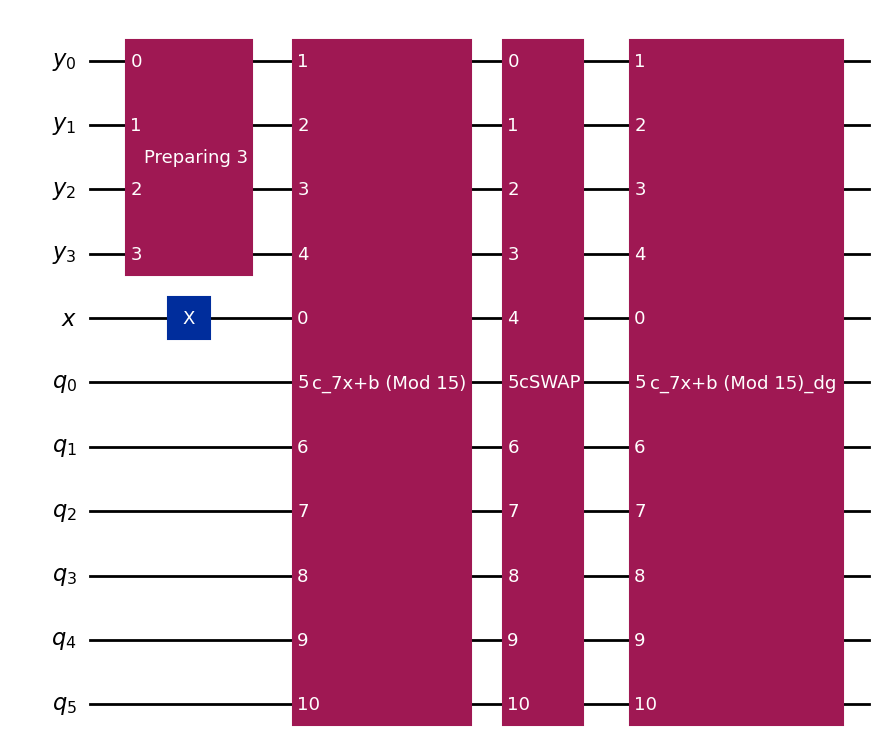

In [22]:
N = 15
a = 7
x = 1
y = 3

qr1 = QuantumRegister(size = n, name = "y")
cr = QuantumRegister(size = 1, name = "x")
qr2 = QuantumRegister(size = n+2, name = "q")
qc = QuantumCircuit(qr1, cr, qr2)

if x == 1:
    qc.x(cr[0]) 
    qc.compose(state_prep(y, N).to_gate(), qr1[-n:], inplace=True)
    qc.compose(cU_a(a, N), inplace=True)
else:
    qc.compose(state_prep(y, N).to_gate(), qr1[-n:], inplace=True)
    qc.compose(cU_a(a, N), inplace=True)

qc.draw("mpl")

In [23]:
psi = Statevector(qc)
psi.draw("Latex")

<IPython.core.display.Latex object>

Wonderful!

Let's also check that when $x=0$, the modular arithmetic does not occur and instead we just return the state $y$.  

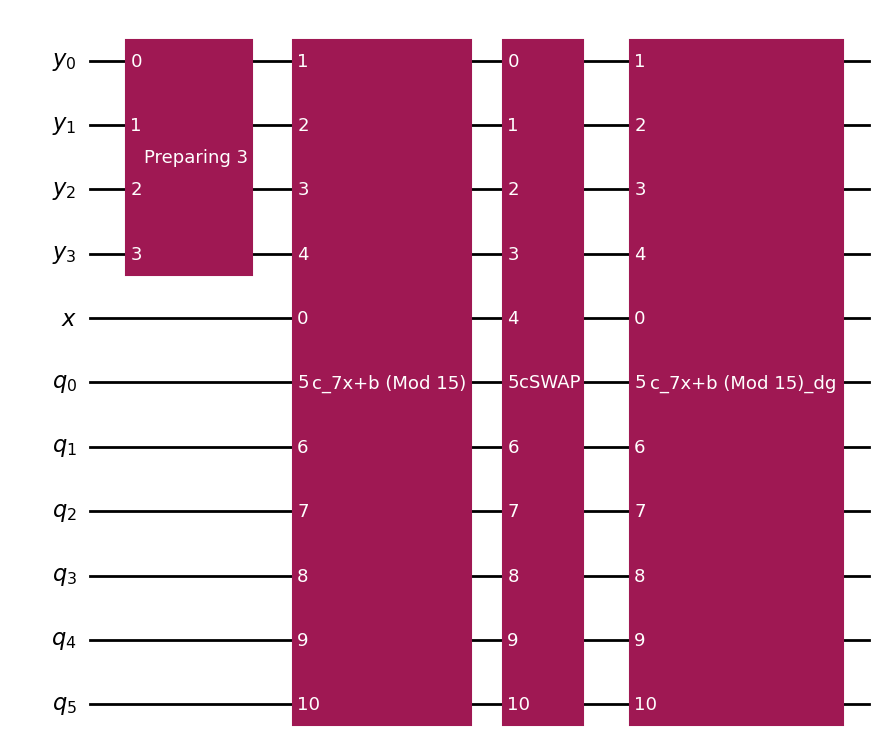

In [24]:
N = 15
a = 7
x = 0
y = 3

qr1 = QuantumRegister(size = n, name = "y")
cr = QuantumRegister(size = 1, name = "x")
qr2 = QuantumRegister(size = n+2, name = "q")
qc = QuantumCircuit(qr1, cr, qr2)

if x == 1:
    qc.x(cr[0]) 
    qc.compose(state_prep(y, N).to_gate(), qr1[-n:], inplace=True)
    qc.compose(cU_a(a, N), inplace=True)
else:
    qc.compose(state_prep(y, N).to_gate(), qr1[-n:], inplace=True)
    qc.compose(cU_a(a, N), inplace=True)

qc.draw("mpl")

In [25]:
psi = Statevector(qc)
psi.draw("Latex")

<IPython.core.display.Latex object>

Magnificent!